# Importing Dependencies

In [28]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image, ImageDraw, ImageFont
import random
import requests
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

# Getting the Model

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

In [5]:
# pip install einops timm

model_id = "microsoft/Florence-2-large"
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval()

print("Model: ", model)
print("Type: ", type(model))

c:\Users\dariu\anaconda3\envs\nn-gpu\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


pytorch_model.bin:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

Model:  Florence2ForConditionalGeneration(
  (vision_tower): DaViT(
    (convs): ModuleList(
      (0): ConvEmbed(
        (proj): Conv2d(3, 256, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (1): ConvEmbed(
        (proj): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (2): ConvEmbed(
        (proj): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (3): ConvEmbed(
        (proj): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
    (blocks): ModuleList(
      (0): MySequential(
        (0): MySequential(
          (spatial_block): SpatialBlock(
            (conv1): PreNorm(
              

In [6]:
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

print("Processor: ", processor)
print("Type: ", type(processor))

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/48.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Processor:  Florence2Processor:
- image_processor: CLIPImageProcessor {
  "auto_map": {
    "AutoProcessor": "microsoft/Florence-2-large--processing_florence2.Florence2Processor"
  },
  "crop_size": {
    "height": 768,
    "width": 768
  },
  "do_center_crop": false,
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_seq_length": 577,
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "processor_class": "Florence2Processor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 768,
    "width": 768
  }
}

- tokenizer: BartTokenizerFast(name_or_path='microsoft/Florence-2-large', vocab_size=50265, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 

# Run Example

In [7]:
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        early_stopping=False,
        num_beams=3,
        do_sample=False
    )

    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )

    return parsed_answer

In [8]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

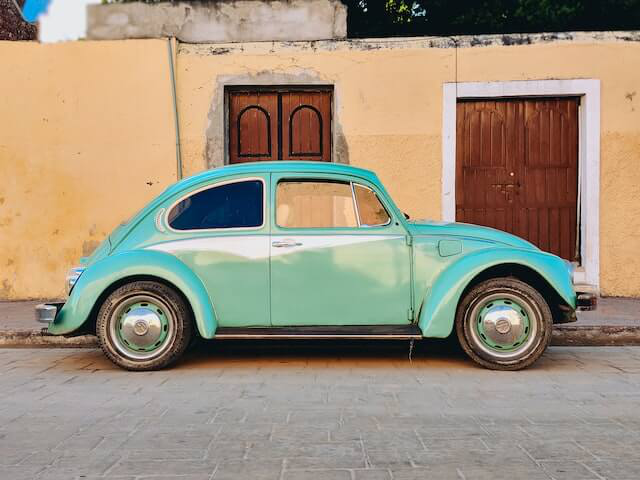

In [9]:
image

# Sample Tasks

In [12]:
task_prompt = "<CAPTION>"
run_example(task_prompt)

{'<CAPTION>': 'A green car parked in front of a yellow building.'}

In [14]:
task_prompt = "<DETAILED_CAPTION>"
run_example(task_prompt)

{'<DETAILED_CAPTION>': 'The image shows a green Volkswagen Beetle parked in front of a yellow building with two brown doors, surrounded by trees and a clear blue sky.'}

In [15]:
task_prompt = "<MORE_DETAILED_CAPTION>"
run_example(task_prompt)

{'<MORE_DETAILED_CAPTION>': 'The image shows a vintage Volkswagen Beetle car parked on a cobblestone street in front of a yellow building with two wooden doors. The car is painted in a bright turquoise color and has a white stripe running along the side. It has two doors on either side of the car, one with a brown door and the other with a white door. The building appears to be old and dilapidated, with peeling paint and crumbling walls. The sky is blue and there are trees in the background.'}

# Object Detection

In [18]:
# Function to plot bounding boxes
def plot_bbox(image, data):
    fig, ax = plt.subplots()

    ax.imshow(image)

    for bbox, label in zip(data['bboxes'], data['labels']):
        x1, y1, x2, y2 = bbox

        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')

        ax.add_patch(rect)

        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))
    
    ax.axis('off')

    plt.show()

In [29]:
# Function to draw polygons
colormap = ['blue', 'orange', 'green', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'red', 'lime', 'indigo', 'violet', 'aqua', 'magenta', 'coral', 'gold', 'tan', 'skyblue']

def draw_polygons(image, prediction, fill_mask=False):
    draw = ImageDraw.Draw(image)

    scale = 1

    for polygons, label in zip(prediction['polygons'], prediction['labels']):
        color = random.choice(colormap)
        fill_color = random.choice(colormap) if fill_mask else None

        for _polygon in polygons:
            _polygon = np.array(_polygon).reshape(-1, 2)
            if len(_polygon) < 3:
                print('Invalid polygon: ', _polygon)
                continue

            _polygon = (_polygon * scale).reshape(-1).tolist()

            if fill_mask:
                draw.polygon(_polygon, outline=color, fill=fill_color)
            else:
                draw.polygon(_polygon, outline=color)

            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)

    display(image)

### Simple Object Detection

In [16]:
task_prompt = "<OD>"
results = run_example(task_prompt)
print(results)

{'<OD>': {'bboxes': [[33.599998474121094, 160.0800018310547, 596.7999877929688, 371.7599792480469], [271.67999267578125, 241.67999267578125, 302.3999938964844, 246.95999145507812], [452.1600036621094, 276.7200012207031, 553.2799682617188, 370.79998779296875], [95.04000091552734, 280.55999755859375, 198.0800018310547, 371.2799987792969]], 'labels': ['car', 'door handle', 'wheel', 'wheel']}}


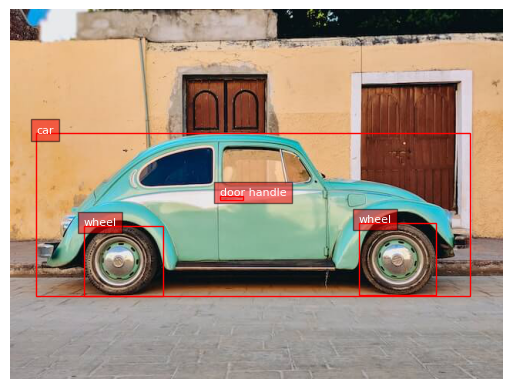

In [19]:
plot_bbox(image, results['<OD>'])

### Dense Region Caption

In [20]:
task_prompt = "<DENSE_REGION_CAPTION>"
results = run_example(task_prompt)
print(results)

{'<DENSE_REGION_CAPTION>': {'bboxes': [[33.599998474121094, 160.0800018310547, 596.7999877929688, 371.7599792480469], [452.1600036621094, 276.7200012207031, 553.2799682617188, 370.79998779296875], [95.04000091552734, 280.55999755859375, 198.0800018310547, 371.2799987792969], [271.67999267578125, 241.67999267578125, 302.3999938964844, 246.95999145507812]], 'labels': ['turquoise Volkswagen Beetle', 'wheel', 'wheel', 'door handle']}}


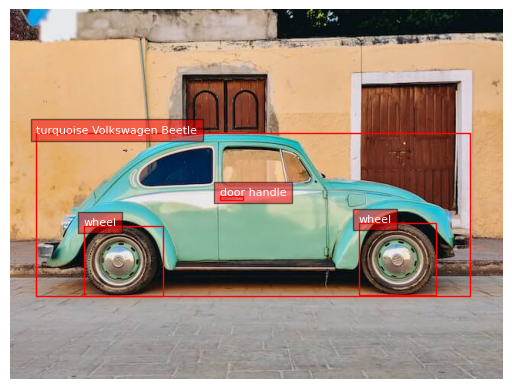

In [21]:
plot_bbox(image, results['<DENSE_REGION_CAPTION>'])

### Region Proposal

In [22]:
task_prompt = "<REGION_PROPOSAL>"
results = run_example(task_prompt)
print(results)

{'<REGION_PROPOSAL>': {'bboxes': [[33.599998474121094, 160.0800018310547, 596.7999877929688, 371.7599792480469], [454.7200012207031, 97.19999694824219, 579.5199584960938, 261.8399963378906], [450.8800048828125, 276.7200012207031, 553.2799682617188, 370.79998779296875], [95.04000091552734, 280.55999755859375, 198.0800018310547, 371.2799987792969], [226.87998962402344, 89.04000091552734, 332.47998046875, 164.39999389648438], [66.23999786376953, 266.6399841308594, 86.72000122070312, 295.91998291015625], [271.67999267578125, 241.67999267578125, 302.3999938964844, 246.95999145507812], [408.0, 308.3999938964844, 413.7599792480469, 320.8800048828125], [509.1199951171875, 172.0800018310547, 514.8800048828125, 176.39999389648438]], 'labels': ['', '', '', '', '', '', '', '', '']}}


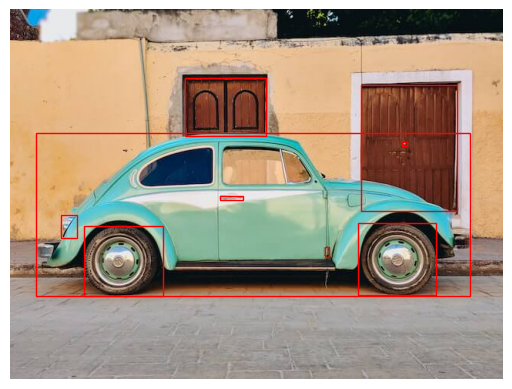

In [23]:
plot_bbox(image, results['<REGION_PROPOSAL>'])

### Caption to Phrase Grounding

In [24]:
task_prompt = "<CAPTION_TO_PHRASE_GROUNDING>"
results = run_example(task_prompt, text_input="A green car parked in front of a yellow building")
print(results)

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[34.880001068115234, 159.1199951171875, 582.0800170898438, 375.1199951171875], [1.5999999046325684, 32.39999771118164, 639.0399780273438, 304.55999755859375]], 'labels': ['A green car', 'a yellow building']}}


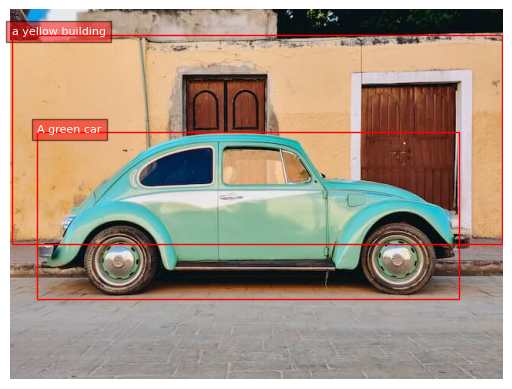

In [25]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### Referring Expression Segmentation

In [26]:
task_prompt = "<REFERRING_EXPRESSION_SEGMENTATION>"
results = run_example(task_prompt, text_input="A green car")
print(results)

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[178.87998962402344, 181.1999969482422, 180.8000030517578, 180.239990234375, 182.72000122070312, 180.239990234375, 187.83999633789062, 176.87998962402344, 189.75999450683594, 176.87998962402344, 192.95999145507812, 174.95999145507812, 194.87998962402344, 174.95999145507812, 198.0800018310547, 173.0399932861328, 200.63999938964844, 172.0800018310547, 203.83999633789062, 171.1199951171875, 207.0399932861328, 170.16000366210938, 210.239990234375, 169.1999969482422, 214.0800018310547, 168.239990234375, 217.9199981689453, 166.8000030517578, 221.75999450683594, 165.83999633789062, 226.239990234375, 164.87998962402344, 230.72000122070312, 163.9199981689453, 237.1199951171875, 162.95999145507812, 244.79998779296875, 162.0, 255.0399932861328, 161.0399932861328, 272.32000732421875, 160.0800018310547, 308.1600036621094, 160.0800018310547, 326.0799865722656, 161.0399932861328, 335.03997802734375, 162.0, 342.0799865722656, 162.95999145507812, 3

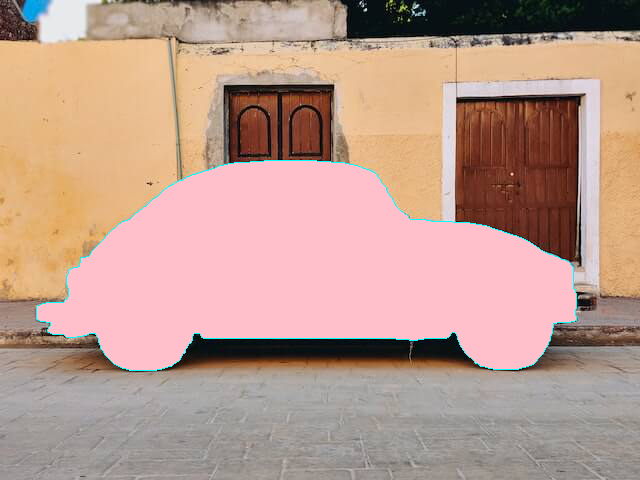

In [33]:
output_image = copy.deepcopy(image)
draw_polygons(output_image, results['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True)

In [34]:
url = "http://ecx.images-amazon.com/images/I/51UUzBDAMsL.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')

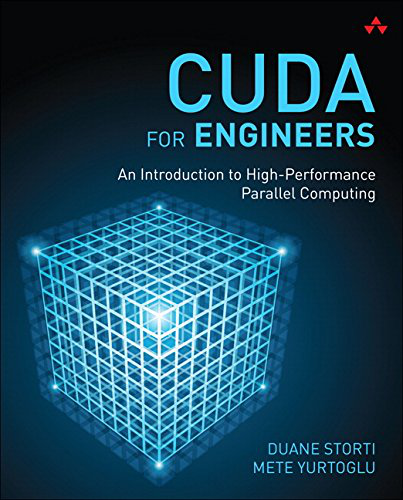

In [35]:
image

### Optical Character Recognition

In [37]:
task_prompt = "<OCR>"
run_example(task_prompt)

KeyboardInterrupt: 